Training the unet, first finetuning with the resnet frozen, then finetuning entire thing.

In [1]:
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Conv2D, UpSampling2D, Input, concatenate
import numpy as np
import matplotlib.image as mpimg
import os
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
import unetModel

In [3]:
import generators

In [4]:
img_width = 768
img_height = 768
img_size = (img_height, img_width)
seed = 42
baseDir = '/home/ubuntu/notebooks/shipid/data/bigboats'
imgDir = os.path.join(baseDir, 'images')
maskDir = os.path.join(baseDir, 'masks')
batchSize = 3

In [19]:
#reload(create_unet)

<module 'create_unet' from '/home/gregw/code/Kaggle/ShipId/kerasUnet/create_unet.py'>

In [5]:
import keras
keras.__version__

'2.2.4'

In [6]:
#reload(unetModel)
#myU = unetModel.getUnet()
myU = unetModel.getUnet('freeze2.h5')

Instructions for updating:
Colocations handled automatically by placer.


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [7]:
myU.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 768, 768, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 774, 774, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 384, 384, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 384, 384, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [7]:
def weighted_cross_entropy(beta):
  def convert_to_logits(y_pred):
      # see https://github.com/tensorflow/tensorflow/blob/r1.10/tensorflow/python/keras/backend.py#L3525
      y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())

      return tf.log(y_pred / (1 - y_pred))

  def wce_loss(y_true, y_pred):
    y_pred = convert_to_logits(y_pred)
    wce_loss = tf.nn.weighted_cross_entropy_with_logits(logits=y_pred, targets=y_true, pos_weight=beta)

    return tf.reduce_mean(wce_loss)

  return wce_loss

In [8]:
def tversky_loss(beta):
  def tv_loss(y_true, y_pred):
    numerator = tf.reduce_sum(y_true * y_pred)
    denominator = y_true * y_pred + beta * (1 - y_true) * y_pred + (1 - beta) * y_true * (1 - y_pred)

    return numerator / (tf.reduce_sum(denominator) + tf.keras.backend.epsilon())

  return tv_loss

In [19]:
reload(generators)

<module 'generators' from '/home/ubuntu/notebooks/shipid/kerasUnet/generators.py'>

In [17]:
train_gen, valid_gen = generators.getTrainValidGenerators(imgDir, maskDir, 0.20, img_size, 4)

Found 136 images belonging to 1 classes.
Found 136 images belonging to 1 classes.
Found 34 images belonging to 1 classes.
Found 34 images belonging to 1 classes.


In [10]:
from keras.optimizers import *
beta = 4.0
tv_beta = 0.8
#myU.compile(optimizer = Adam(lr = 1e-4), loss = keras.losses.binary_crossentropy, 
#            metrics = ['accuracy', weighted_cross_entropy(beta), tversky_loss(tv_beta)])
myU.compile(optimizer = Adam(lr = 1e-4), loss = weighted_cross_entropy(beta), 
            metrics = ['accuracy', weighted_cross_entropy(beta), keras.losses.binary_crossentropy, tversky_loss(tv_beta)])


In [18]:
myU.fit_generator( 
            train_gen,
            steps_per_epoch = 26,
            validation_data = valid_gen,
            validation_steps = 6,
            epochs = 1
            )

Epoch 1/1


ResourceExhaustedError: OOM when allocating tensor with shape[4,131,768,768] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node training/Adam/gradients/conv2d_9/convolution_grad/Conv2DBackpropInput}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


In [15]:
myU.fit_generator( 
            train_gen,
            steps_per_epoch = 26,
            validation_data = valid_gen,
            validation_steps = 6,
            epochs = 2
            )

Epoch 1/2
26/26 [==============================] - 101s 4s/step - loss: 0.0379 - acc: 0.9926 - val_loss: 0.0808 - val_acc: 0.9839
Epoch 2/2
26/26 [==============================] - 99s 4s/step - loss: 0.0215 - acc: 0.9929 - val_loss: 0.0711 - val_acc: 0.9876


In [16]:
myU.save('freeze2.h5')

In [12]:
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator


In [13]:
test_dir = '/home/ubuntu/notebooks/shipid/data/bigboats/test'
test_datagen = ImageDataGenerator()

In [14]:
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(768,768), batch_size=1, class_mode=None)

Found 10 images belonging to 1 classes.


In [15]:
y_pred4 = myU.predict_generator(test_generator, verbose=1, steps=10)

10/10 [==============================] - 18s 2s/step


In [43]:
y_pred.shape

(10, 768, 768, 1)

In [37]:
newd = np.reshape(y_pred[0],(768, 768))

In [38]:
newd.ndim

2

In [58]:
mpimg.imsave('mask_1.png', newd*255, cmap='gray')

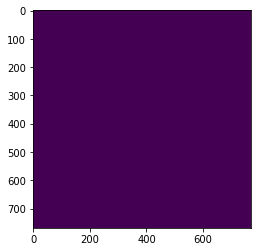

In [59]:
plt.imshow(newd)
plt.show()

In [61]:
i = 0
for img in y_pred:
    newd = np.reshape(img, (768, 768)) * 255
    fname = 'mask_' + str(i) + '.png'
    mpimg.imsave(fname, newd, cmap='gray')
    i = i + 1

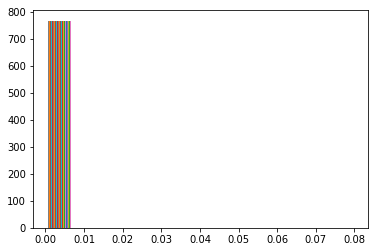

In [73]:
#hist = np.histogram(y_pred[0])
plt.hist(np.reshape(y_pred[1]*1000, (768, 768)), bins='auto')
#plt.hist(np.reshape(y_pred[0]*100000, (768, 768)), bins=[0.00000001, 0.0000001, 0.000001, 0.0001, 1])
plt.show()


In [39]:
test_generator.filenames

['boats/0027854cc.jpg',
 'boats/002d56570.jpg',
 'boats/0040cf4e9.jpg',
 'boats/009751652.jpg',
 'boats/00d0a646b.jpg',
 'boats/00fd8e126.jpg',
 'boats/0106d2433.jpg',
 'boats/014624873.jpg',
 'boats/014c906b1.jpg',
 'boats/016017695.jpg']

In [40]:
test_generator.index_array

array([0, 8, 7, 3, 1, 4, 2, 9, 5, 6])

In [97]:
fn = test_generator.filenames[2]
base, ext = os.path.splitext(fn)
fn = base + ".png"
print(fn)

boats/0040cf4e9.png


In [19]:
mask_dir = '/home/ubuntu/notebooks/shipid/data/bigboats/masks'
#mk = mpimg.imread(os.path.join(mask_dir,fn))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


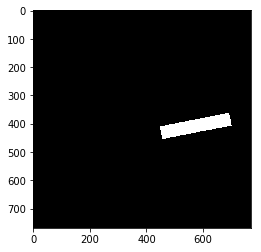

In [101]:
plt.imshow(mk*255)
plt.show()

In [100]:
np.amax(mk)

1.0

In [104]:
mk.shape[1]

768

In [108]:
mk.shape
mk[0,0,0]

0.0

In [20]:
i = 0
for fileIdx in test_generator.index_array:
    pred_mask = y_pred2[i]
    
    # Get name of target mask, read it in.
    fn = test_generator.filenames[fileIdx]
    base, ext = os.path.splitext(fn)
    filename = base + ".png"
    mask = mpimg.imread(os.path.join(mask_dir,filename))

    # See if nonzero pixels in target mask and predicted mask match, same with zeros.
    hits = 0
    misses = 0
    targetOnes = 0
    predOnes = 0
    for row in range(0, mask.shape[0]-1):
        for col in range(0, mask.shape[1]-1):
            if mask[row, col, 0] > 0 and pred_mask[row, col, 0] > 0:
                hits += 1
            elif mask[row, col, 0] == 0 and pred_mask[row, col, 0] == 0:
                hits += 1
            else:
                misses += 1
            if mask[row, col, 0] > 0:
                targetOnes += 1
            if pred_mask[row, col, 0] > 0:
                predOnes += 1
    print( "for image: ", filename, " had ", hits, " hits and ", misses, " misses, target ones=", targetOnes,
          ", predicted ones=", predOnes)
    i += 1


for image:  boats/00fd8e126.png  had  11293  hits and  576996  misses, target ones= 10639 , predicted ones= 587635
for image:  boats/00d0a646b.png  had  91833  hits and  496456  misses, target ones= 10844 , predicted ones= 504546
for image:  boats/0040cf4e9.png  had  11456  hits and  576833  misses, target ones= 11410 , predicted ones= 588243
for image:  boats/014c906b1.png  had  6310  hits and  581979  misses, target ones= 4697 , predicted ones= 586676
for image:  boats/016017695.png  had  4714  hits and  583575  misses, target ones= 4714 , predicted ones= 588289
for image:  boats/0106d2433.png  had  3113  hits and  585176  misses, target ones= 3061 , predicted ones= 588237
for image:  boats/0027854cc.png  had  1754  hits and  586535  misses, target ones= 1754 , predicted ones= 588289
for image:  boats/002d56570.png  had  8372  hits and  579917  misses, target ones= 1292 , predicted ones= 581187
for image:  boats/014624873.png  had  10573  hits and  577716  misses, target ones= 10573 

In [45]:
pred1 = y_pred[1,:,:,0]
print(np.amax(pred1))
#scalefactor = 255/np.amax(pred1)
#scalepred1 = pred1 * scalefactor
#print(np.amax(scalepred1))
print(test_generator.filenames[test_generator.index_array[0]])

0.9767386
boats/014c906b1.jpg


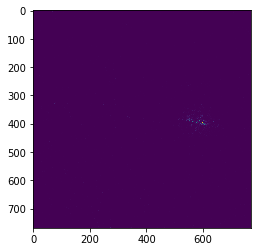

In [46]:
plt.imshow(pred1)

In [32]:
np.amax(pred1)
pred1.shape

(768, 768)

(array([5.89401e+05, 2.30000e+02, 9.00000e+01, 3.80000e+01, 2.60000e+01,
        1.70000e+01, 6.00000e+00, 1.00000e+01, 2.00000e+00, 4.00000e+00]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <a list of 10 Patch objects>)

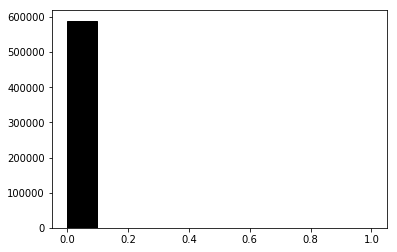

In [47]:
plt.hist(pred1.ravel(), bins=10, range=(0.0, 1.0), fc='k', ec='k')
#plt.hist(np.reshape(y_pred[0]*100000, (768, 768)), bins=[0.00000001, 0.0000001, 0.000001, 0.0001, 1])
#plt.show()

(array([5.89401e+05, 2.30000e+02, 9.00000e+01, 3.80000e+01, 2.60000e+01,
        1.70000e+01, 6.00000e+00, 1.00000e+01, 2.00000e+00, 4.00000e+00]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

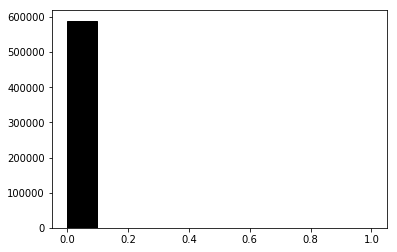

In [48]:
plt.hist(pred1.ravel(), bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], fc='k', ec='k')


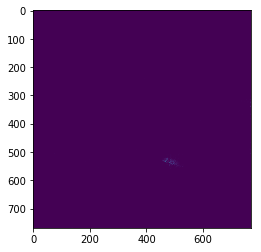

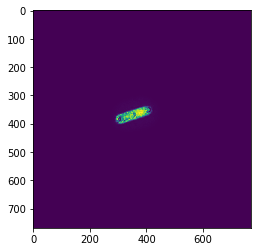

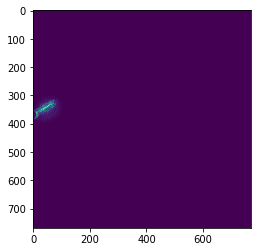

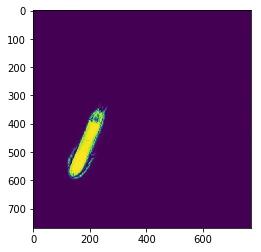

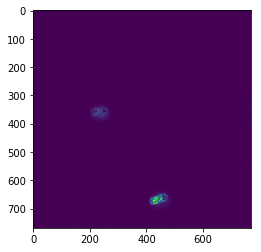

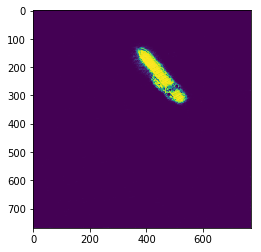

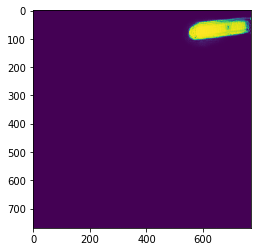

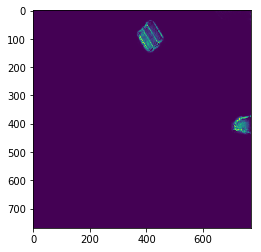

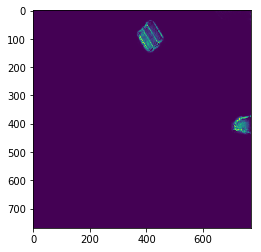

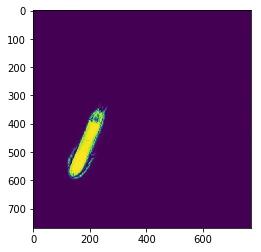

In [27]:
# Beta=2
for i in range(0, len(y_pred1)):
    plt.imshow(y_pred1[i,:,:,0])
    plt.show()

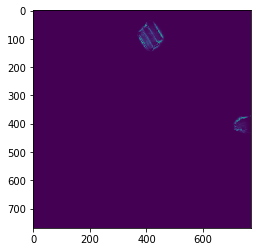

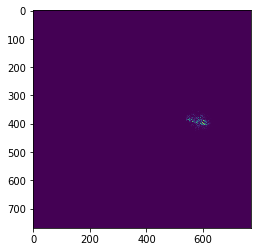

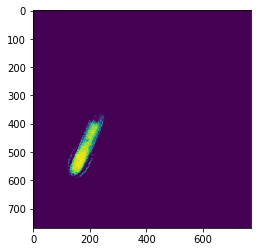

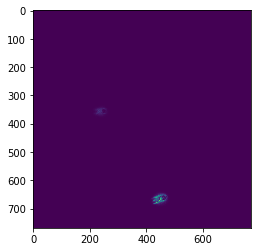

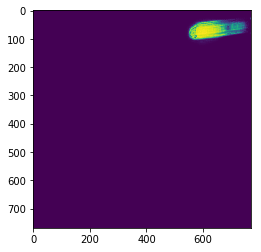

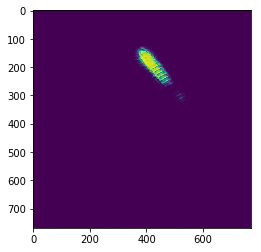

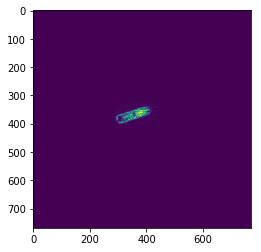

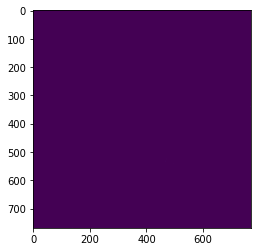

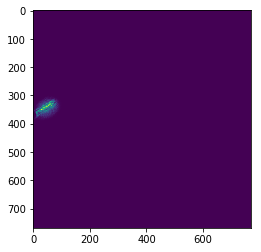

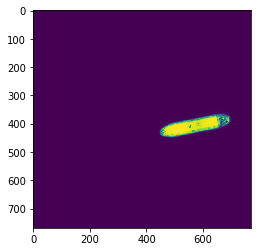

In [17]:
# Beta=1
for i in range(0, len(y_pred3)):
    plt.imshow(y_pred3[i,:,:,0])
    plt.show()

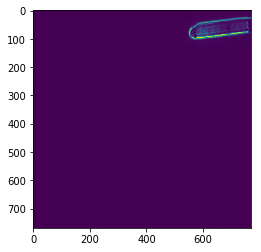

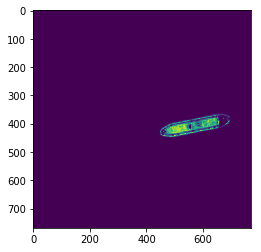

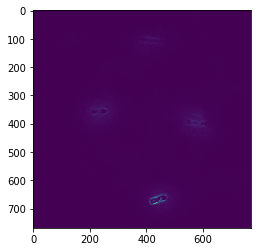

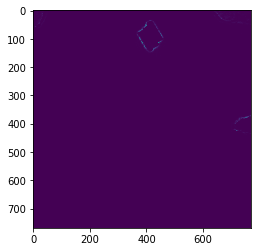

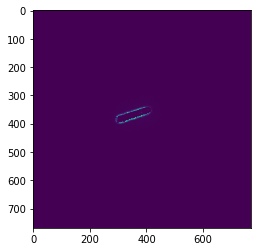

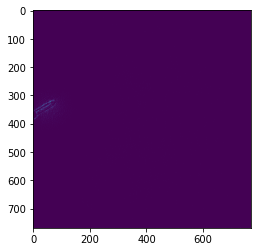

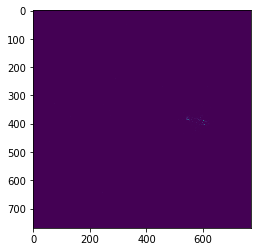

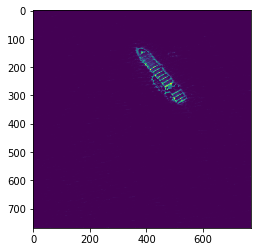

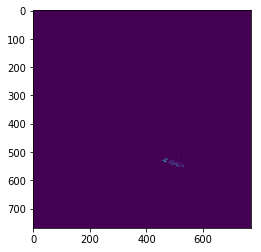

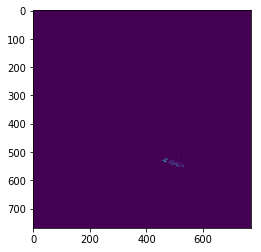

In [22]:
#Beta=0.5
for i in range(0, len(y_pred3)):
    plt.imshow(y_pred3[i,:,:,0])
    plt.show()

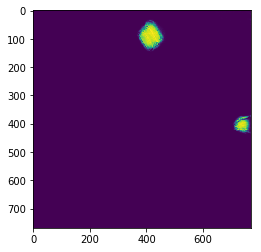

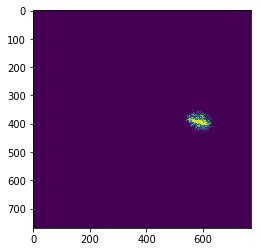

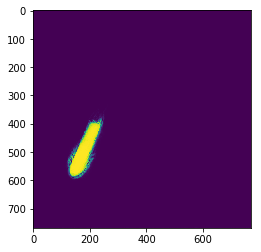

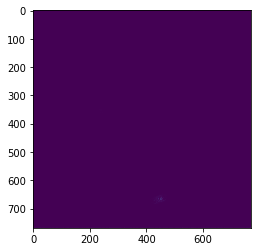

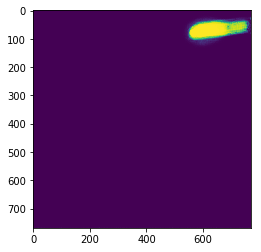

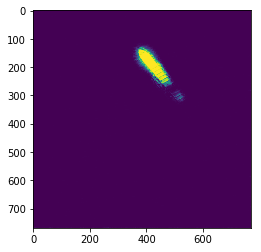

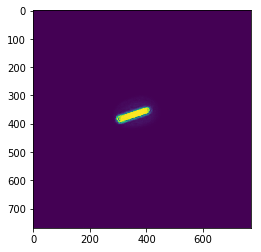

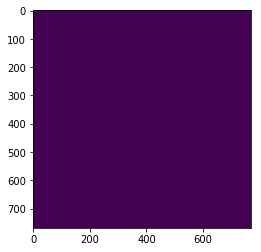

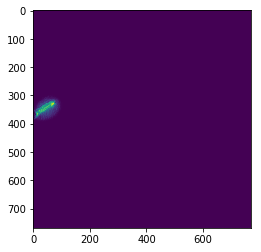

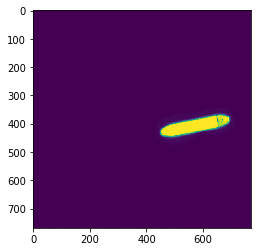

In [16]:
#Beta=4.0
for i in range(0, len(y_pred4)):
    plt.imshow(y_pred4[i,:,:,0])
    plt.show()